In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ConvNext, ViT

import trainer as train_funct
from trainer import Trainer

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [4]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 33075
Validation: 4000
Test: 4000


In [7]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [8]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


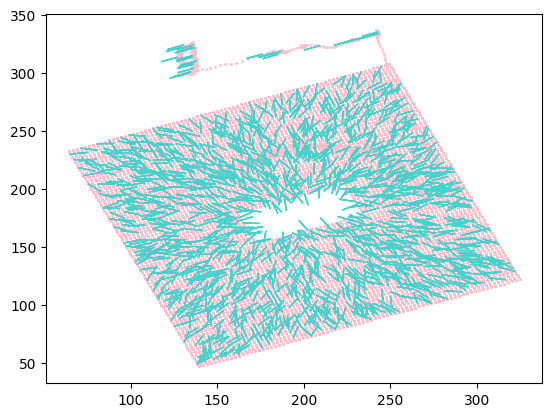

In [9]:
plotter.plot_train_data(train_data)

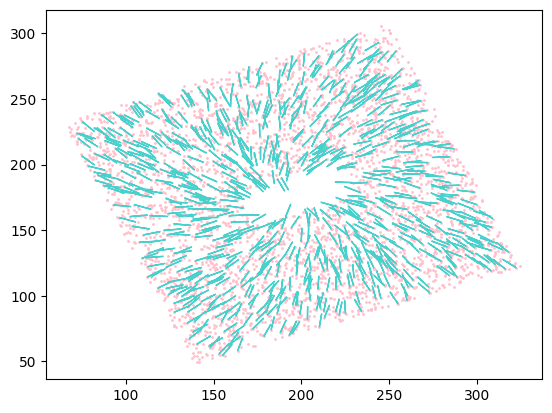

In [10]:
plotter.plot_data(val_data)

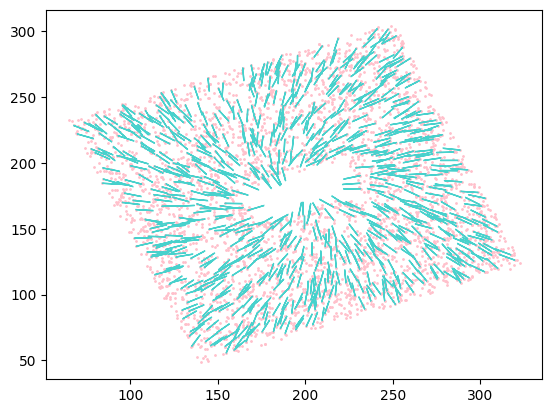

In [11]:
plotter.plot_data(test_data)

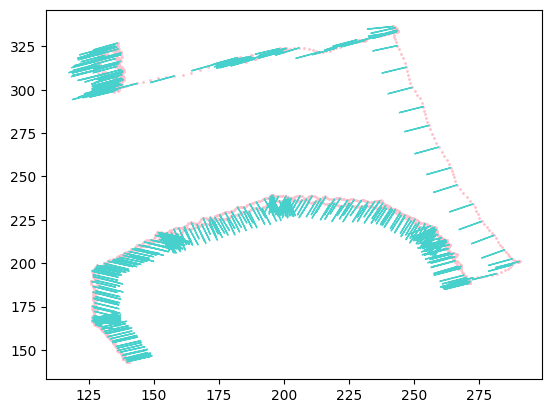

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Training before filtering: 33075


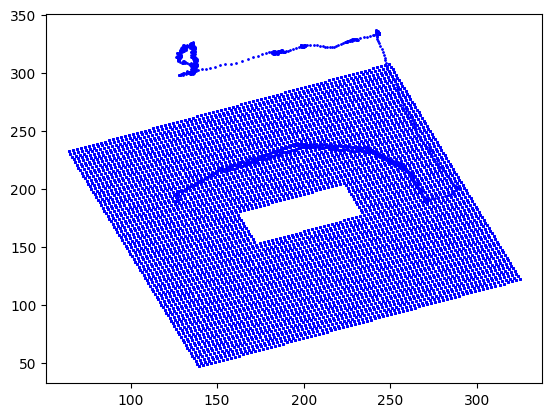

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
print("Training before filtering: " + str(len(train_data.imgs)))

Filtering poses: 100%|████████████████| 33075/33075 [00:00<00:00, 389801.92it/s]


Train after filtering: 28260


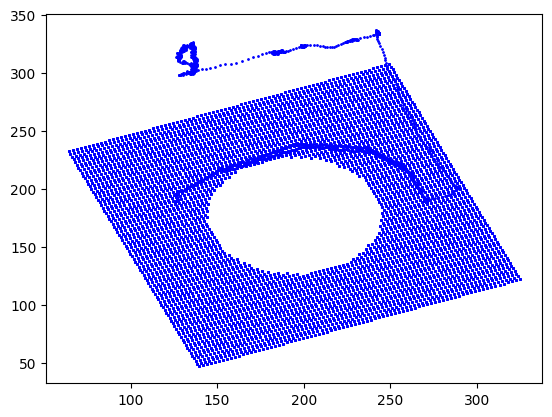

In [15]:
visualizer.filter_train_data(train_data)

plotter.plot_synth_poses_train(train_data, "blue")

print("Train after filtering: " + str(len(train_data.imgs)))

Validation before filtering: 4000


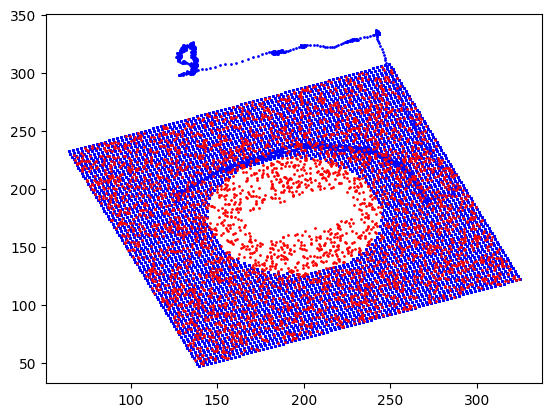

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1749.98it/s]


Validation after filtering: 3490


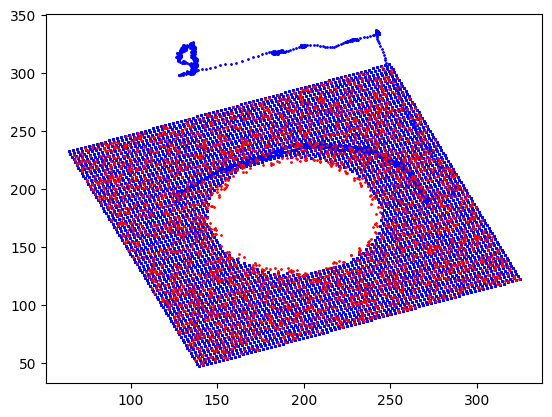

In [17]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


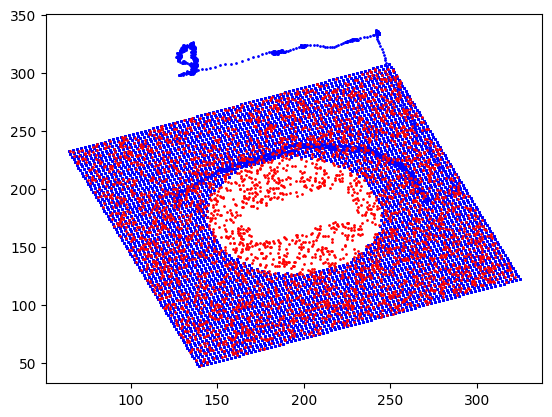

In [18]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1783.22it/s]


Test after filtering: 3502


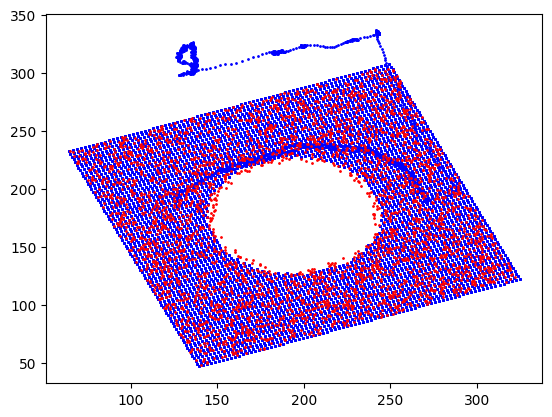

In [19]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 1.0
yaw difference tensor(0.) deg
localization error:  0.0 meters


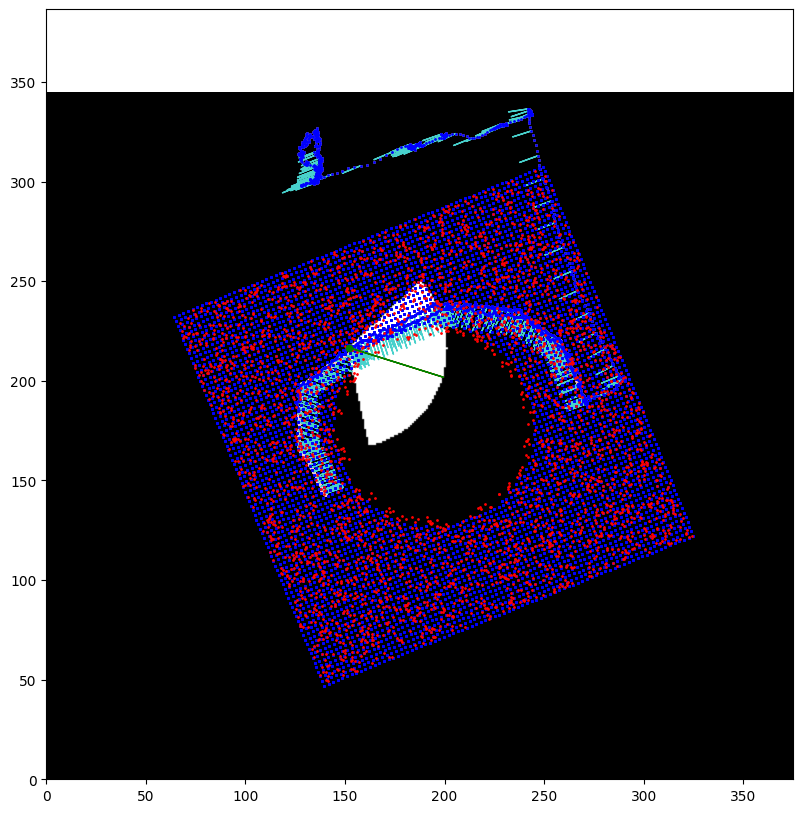

<Figure size 640x480 with 0 Axes>

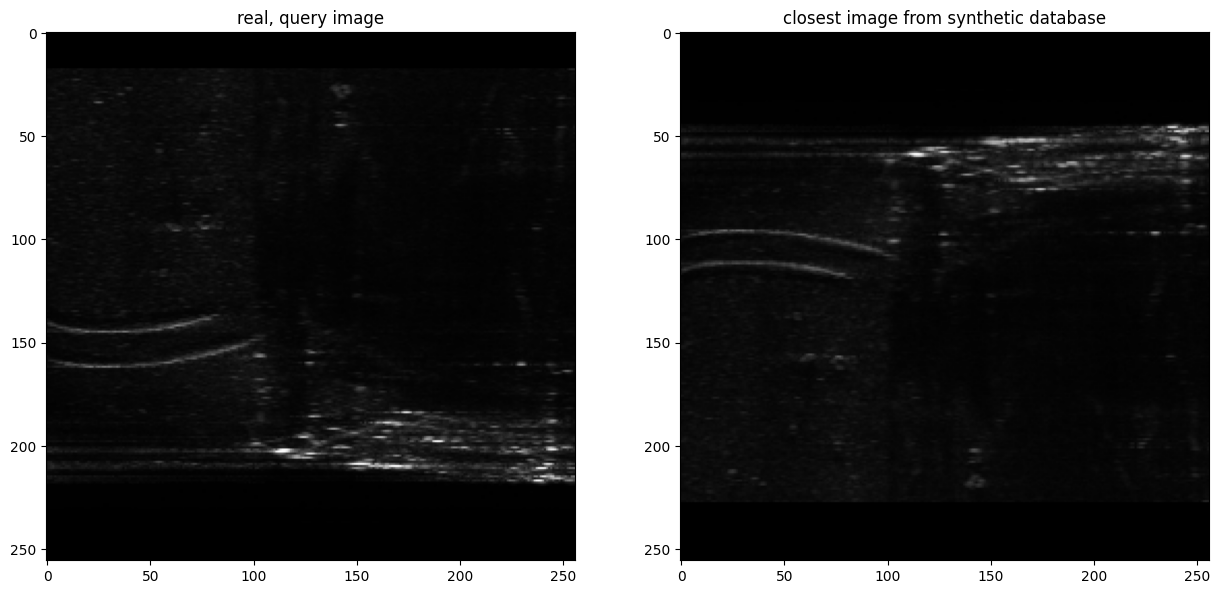

In [20]:
visualizer.localization(train_data, val_data, real_data)

In [21]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 28260
Validation: 3490
Test: 3502


In [22]:
val_data = visualizer.check_gt(train_data, val_data)

In [23]:
test_data = visualizer.check_gt(train_data, test_data)

In [24]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 28260
Validation: 3445
Test: 3462


In [25]:
model_name = "PVT"

In [26]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [27]:
net = PVT.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [28]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [29]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  118920074


## Training Pipeline

### Train epochs

In [30]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, val_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path, best_val_loca_error, best_val_orie_error = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1660/1660 [40:32<00:00,  1.47s/it]


train loss mean: 0.07738834787833404
train loss reco: 0.012451983459787555
train loss loca: 0.006493636145374277


100%|█████████████████████████████████████████| 218/218 [05:20<00:00,  1.47s/it]


val loss mean: 0.02741894558277152
val loss reco: 0.005502134679022048
val loss loca: 0.002191681089627326
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:53<00:00, 233.09it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:14<00:00, 234.07it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:48<00:00,  7.44it/s]


average localization error: 2.5584 meters
average orientation error : 21.6927 degrees
epoch: 2


100%|███████████████████████████████████████| 1660/1660 [41:23<00:00,  1.50s/it]


train loss mean: 0.026120678642876895
train loss reco: 0.005668084316673767
train loss loca: 0.0020452594303200585


100%|█████████████████████████████████████████| 218/218 [05:21<00:00,  1.47s/it]


val loss mean: 0.01736948200407515
val loss reco: 0.0053435421138660075
val loss loca: 0.001202593991957998
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:53<00:00, 234.22it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:14<00:00, 244.68it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:38<00:00,  7.61it/s]


average localization error: 2.5196 meters
average orientation error : 21.8088 degrees
epoch: 3


100%|███████████████████████████████████████| 1660/1660 [40:50<00:00,  1.48s/it]


train loss mean: 0.021421605992097272
train loss reco: 0.005318192718270044
train loss loca: 0.001610341329788172


100%|█████████████████████████████████████████| 218/218 [05:13<00:00,  1.44s/it]


val loss mean: 0.02618268541479056
val loss reco: 0.005236216130828775
val loss loca: 0.002094646932347891
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:42<00:00, 258.01it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 258.17it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:38<00:00,  7.61it/s]


average localization error: 2.4243 meters
average orientation error : 20.7336 degrees
epoch: 4


100%|███████████████████████████████████████| 1660/1660 [40:32<00:00,  1.47s/it]


train loss mean: 0.015261152152712626
train loss reco: 0.005290179802890284
train loss loca: 0.0009970972343054825


100%|█████████████████████████████████████████| 218/218 [05:18<00:00,  1.46s/it]


val loss mean: 0.01826330360640353
val loss reco: 0.005207647375096012
val loss loca: 0.0013055656160817508
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:52<00:00, 236.61it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:14<00:00, 236.34it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:37<00:00,  7.62it/s]


average localization error: 2.6585 meters
average orientation error : 22.4936 degrees
epoch: 5


100%|███████████████████████████████████████| 1660/1660 [39:56<00:00,  1.44s/it]


train loss mean: 0.022436048261013374
train loss reco: 0.005274922038002097
train loss loca: 0.0017161126165434785


100%|█████████████████████████████████████████| 218/218 [05:07<00:00,  1.41s/it]


val loss mean: 0.013038409779856512
val loss reco: 0.0052047299814982975
val loss loca: 0.0007833679814912687
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:41<00:00, 261.53it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 261.12it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:30<00:00,  7.75it/s]


average localization error: 2.8074 meters
average orientation error : 23.6700 degrees
epoch: 6


100%|███████████████████████████████████████| 1660/1660 [39:07<00:00,  1.41s/it]


train loss mean: 0.01770181907565299
train loss reco: 0.005267166002395462
train loss loca: 0.0012434653074519866


100%|█████████████████████████████████████████| 218/218 [05:07<00:00,  1.41s/it]


val loss mean: 0.019647893760729274
val loss reco: 0.005207720300216877
val loss loca: 0.0014440173387619316
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:40<00:00, 265.29it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 263.56it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:35<00:00,  7.66it/s]


average localization error: 3.5941 meters
average orientation error : 29.5969 degrees
epoch: 7


100%|███████████████████████████████████████| 1660/1660 [39:06<00:00,  1.41s/it]


train loss mean: 0.01653434446597674
train loss reco: 0.005263208265764168
train loss loca: 0.0011271136197302186


100%|█████████████████████████████████████████| 218/218 [05:06<00:00,  1.41s/it]


val loss mean: 0.016785744953592984
val loss reco: 0.005189330836142832
val loss loca: 0.0011596414140412805
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:42<00:00, 259.94it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 258.88it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:36<00:00,  7.65it/s]


average localization error: 3.9792 meters
average orientation error : 32.9643 degrees
epoch: 8


100%|███████████████████████████████████████| 1660/1660 [39:07<00:00,  1.41s/it]


train loss mean: 0.023208113860181834
train loss reco: 0.008750456166790281
train loss loca: 0.0014457657823224663


100%|█████████████████████████████████████████| 218/218 [05:06<00:00,  1.41s/it]


val loss mean: 0.008176679024472833
val loss reco: 0.005334601679885196
val loss loca: 0.0002842077328500428
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:39<00:00, 267.21it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 263.73it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:29<00:00,  7.76it/s]


average localization error: 6.7920 meters
average orientation error : 58.9557 degrees
epoch: 9


100%|███████████████████████████████████████| 1660/1660 [39:06<00:00,  1.41s/it]


train loss mean: 0.007337849531378822
train loss reco: 0.005323152506937194
train loss loca: 0.00020146970256031504


100%|█████████████████████████████████████████| 218/218 [05:06<00:00,  1.41s/it]


val loss mean: 0.00801816390434263
val loss reco: 0.005223559711231004
val loss loca: 0.0002794604210099985
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:40<00:00, 263.60it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 262.05it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:29<00:00,  7.76it/s]


average localization error: 6.3555 meters
average orientation error : 56.0399 degrees
epoch: 10


100%|███████████████████████████████████████| 1660/1660 [39:03<00:00,  1.41s/it]


train loss mean: 0.007750452855736556
train loss reco: 0.005282419590919043
train loss loca: 0.000246803325680081


100%|█████████████████████████████████████████| 218/218 [05:06<00:00,  1.41s/it]


val loss mean: 0.008421722825172298
val loss reco: 0.0052080606110394
val loss loca: 0.0003213662193456495
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:37<00:00, 273.04it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:12<00:00, 272.08it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:24<00:00,  7.84it/s]


average localization error: 6.4295 meters
average orientation error : 56.9814 degrees
epoch: 11


100%|███████████████████████████████████████| 1660/1660 [39:00<00:00,  1.41s/it]


train loss mean: 0.008902492657225265
train loss reco: 0.00527318228002503
train loss loca: 0.00036293103744739424


100%|█████████████████████████████████████████| 218/218 [05:06<00:00,  1.41s/it]


val loss mean: 0.018308395964153314
val loss reco: 0.005204594281818205
val loss loca: 0.0013103801632271183
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:40<00:00, 264.42it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 263.14it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:33<00:00,  7.69it/s]


average localization error: 6.6275 meters
average orientation error : 57.9265 degrees
epoch: 12


100%|███████████████████████████████████████| 1660/1660 [38:53<00:00,  1.41s/it]


train loss mean: 0.016815200274114508
train loss reco: 0.005268758057381015
train loss loca: 0.001154644221426142


100%|█████████████████████████████████████████| 218/218 [05:05<00:00,  1.40s/it]


val loss mean: 0.023158979815764164
val loss reco: 0.005203885489801338
val loss loca: 0.0017955094317418582
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:40<00:00, 265.36it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 263.81it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:28<00:00,  7.78it/s]


average localization error: 6.3583 meters
average orientation error : 54.8489 degrees
Training time:  39196.57223391533 seconds


In [31]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

Inference time per image:  0.0006312280893325806 seconds


In [32]:
input_tensor = next(iter(val_dataloader))[0].cuda()
inference_memory_per_batch = metrics.inference_memory(net, input_tensor)
print("Inference memory for batch: ", inference_memory_per_batch, "MB")

Inference memory for batch:  1090.41259765625 MB


In [33]:
metrics.get_descriptors(train_data, val_data, net)

100%|████████████████████████████████████| 26560/26560 [01:42<00:00, 259.97it/s]


computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:41<00:00, 261.07it/s]


descriptors computed!


/home/firp/Desktop/Notebook_bsd/metrics.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:13<00:00, 263.35it/s]


descriptors computed!
torch.Size([3488]) torch.Size([3488, 5])
avg_metric_e     : tensor(113.4231)
avg_metric_e_top5: tensor(50.7404)


## Visualize Training results on Test data

### Load the checkpoint model

In [51]:
#checkpoint_path = best_model_path
#print("Best model path: ", best_model_path)
#print("Validation loca error with best model: ", best_val_loca_error)
#print("Validation orie error with best model: ", best_val_orie_error)
checkpoint_path = "correct_model_3/epoch_03.pth"
net = PVT.Model()
train_funct.load_state(net, checkpoint_path)

net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [52]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [01:56<00:00, 227.81it/s]

descriptors computed!


### Visualize query results: sonar images

In [53]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 256, 2, 2]) tensor(-0.8236, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6647, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 4, 4]) tensor(-0.8044, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6133, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 16, 16]) tensor(-1.2277, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8766, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 8, 8]) tensor(-1.4781, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2773, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5861, device='cuda:0', grad_fn=<MinBackward1>) tensor(-0.3912, device='cuda:0', grad_fn=<MaxBackward1>)


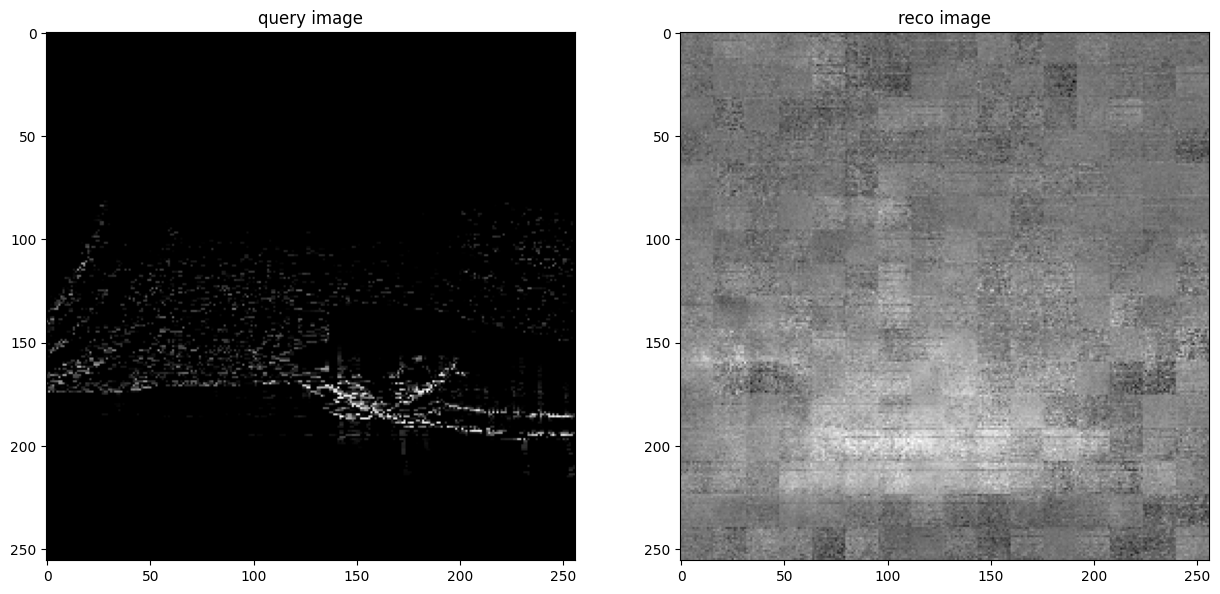

In [54]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.4607908410100329
localization error: 2.2638 meters
orientation error : 16.0908 degrees


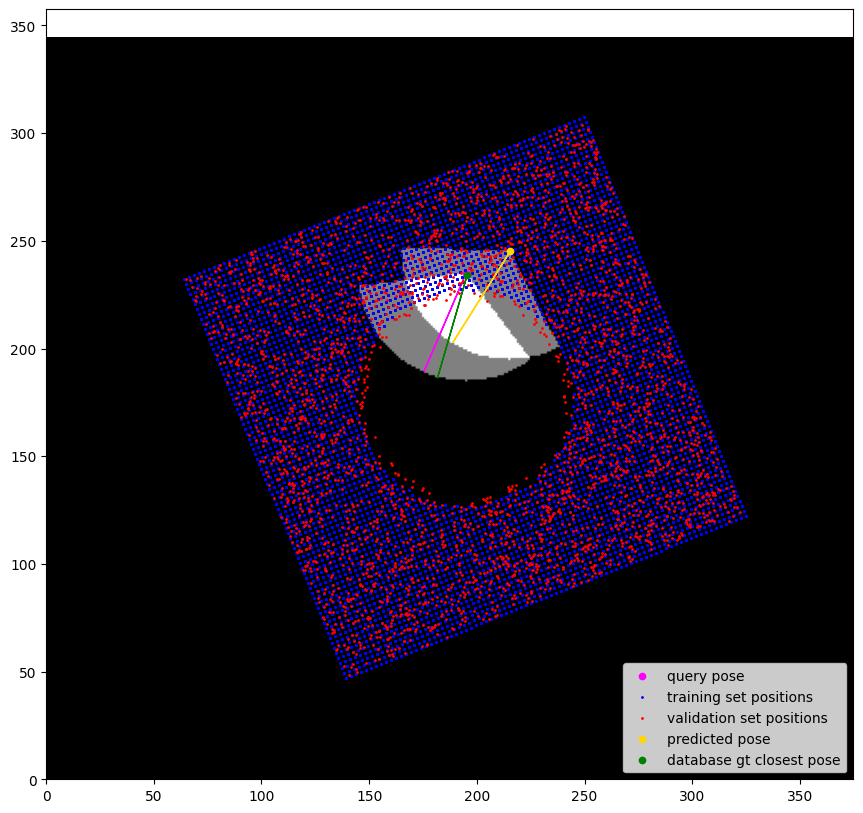

<Figure size 640x480 with 0 Axes>

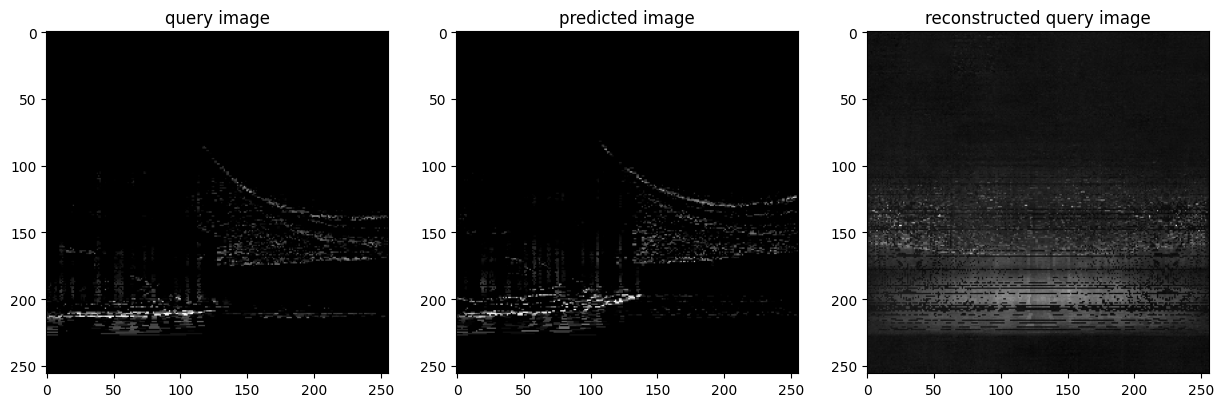

In [55]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [56]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

100%|███████████████████████████████████████| 3496/3496 [07:42<00:00,  7.56it/s]

average localization error: 2.5953 meters
average orientation error : 22.4038 degrees


In [57]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [58]:
loca_errors.argmax()

np.int64(1971)

In [59]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

1.2951751
3.590409


## Process real images

query_idx: 142
244.01001 230.0 2.7565112 -22.063538
iou: 0.0
localization error Upper:  6.5797663 meters


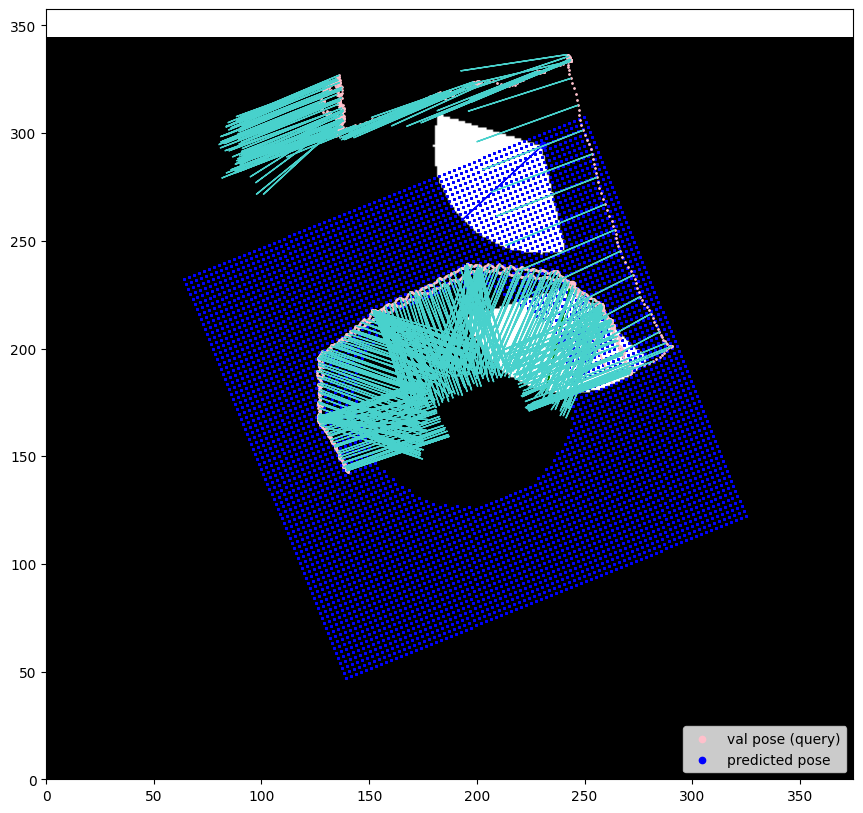

<Figure size 640x480 with 0 Axes>

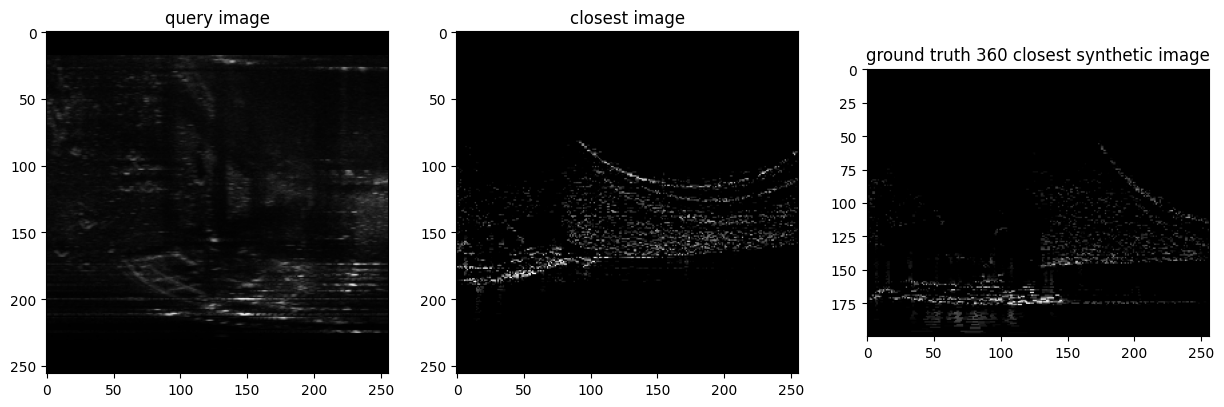

In [60]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [61]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [62]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|████████████████████████████████████████| 710/710 [00:03<00:00, 230.29it/s]

descriptors computed!


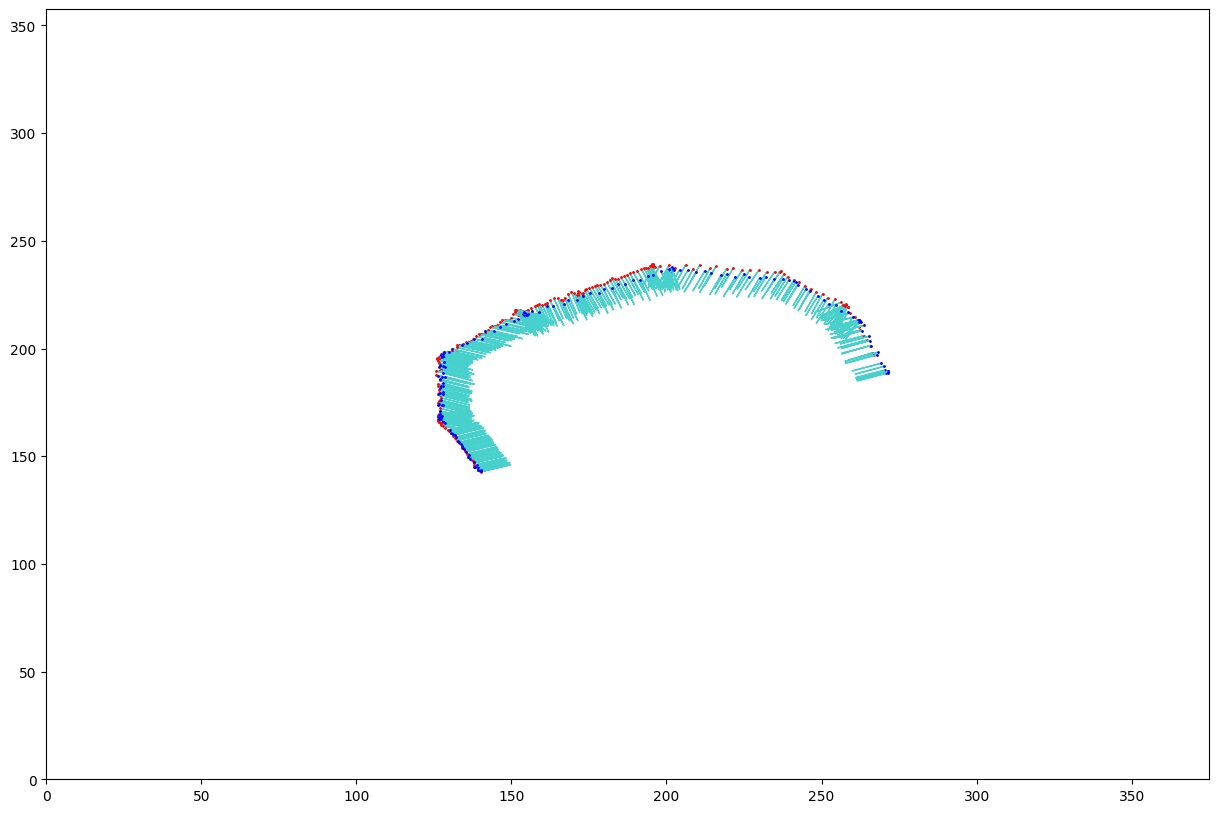

In [63]:
visualizer.visualize_real(train_data, real_data)

iou: 0.8639591385448492
localization error: 0.0932 meters
orientation error : 1.7303 degrees


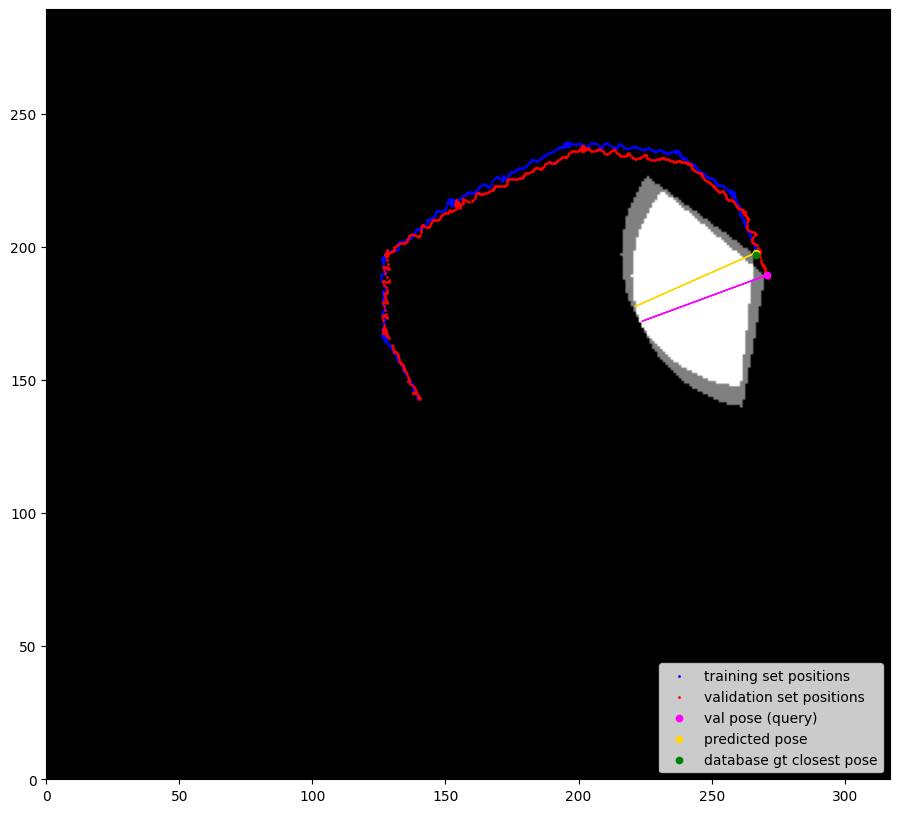

<Figure size 640x480 with 0 Axes>

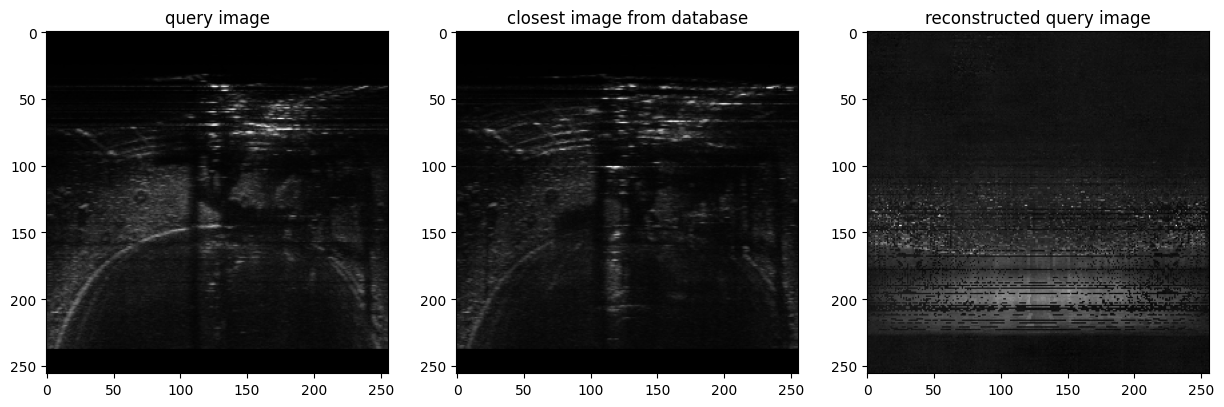

In [64]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [65]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:15<00:00, 51.12it/s]

average localization error: 2.6473 meters
average orientation error : 28.8310 degrees


In [66]:
avg_orie_error.min()

np.float32(28.830961)

## Results

In [50]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, inference_memory_per_batch, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Inference memory per batch: {inference_memory_per_batch:6.4f} MB")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")

Model name: ViT
Total parameters: 118920074
Training time: 39196.5722 seconds
Inference time per image: 0.0006 seconds
Inference memory per batch: 1090.4126 MB
Average localization error in Test: 6.4884 meters
Average orientation error in Test: 56.6336 degrees
Average localization error in Real: 5.3460 meters
Average orientation error in Real: 54.6397 degrees
